In [ ]:
# Google Colab Setup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    import sys

    # Path to the project root in Google Drive
    project_root = '/content/drive/MyDrive/ComputerVisionTest'

    if os.path.exists(project_root):
        # Change to project root to install requirements
        os.chdir(project_root)
        print("Installing requirements...")
        !pip install -q -r requirements.txt

        # Add project root to sys.path
        if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added {project_root} to sys.path")

        # Change directory to 'notebooks' so relative paths work
        notebooks_dir = os.path.join(project_root, 'notebooks')
        if os.path.exists(notebooks_dir):
            os.chdir(notebooks_dir)
            print(f"Changed directory to {notebooks_dir}")
    else:
        print(f"Warning: Project root {project_root} not found. Please check your Drive path.")

except ImportError:
    # Local Machine Setup
    import os
    import sys

    # Get the path to the project root (assuming running from notebooks/)
    current_dir = os.getcwd()
    if current_dir.endswith('notebooks'):
        project_root = os.path.abspath('..')
    else:
        project_root = os.path.abspath('.')

    if os.path.exists(os.path.join(project_root, 'src')):
         if project_root not in sys.path:
            sys.path.append(project_root)
            print(f"Added project root to sys.path: {project_root}")


# Model Evaluation & Analysis

This notebook evaluates the trained ResNet50 model using the **Test Set**.
It covers quantitative metrics (Accuracy, F1-Score), Confusion Matrix, and Error Analysis.

In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt

# Add src to path
sys.path.append(os.path.abspath('../'))

from src.data.loader import create_dataloaders
from src.models.base_model import get_model
from src.utils.evaluation import evaluate_model, plot_confusion_matrix, print_classification_report, visualize_misclassifications
from src.utils.seeds import set_seeds

%matplotlib inline
set_seeds(42)

Global seed set to 42


## Load Environment

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
print(f"Using device: {DEVICE}")

Using device: cpu


## Load Data & Model
We load the **Test Set** and the best saved model (`best_model.pt`).

In [3]:
_, _, test_loader = create_dataloaders(data_dir='../src/data', batch_size=BATCH_SIZE)

model = get_model(num_classes=102, fine_tune=False)
model_path = '../notebooks/best_model.pt' # Assuming saved in notebooks dir by trainer

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    print("Loaded best model.")
else:
    print("Warning: best_model.pt not found. Using untrained weights (Evaluation will be poor).")

model = model.to(DEVICE)

Loaded best model.


## Quantitative Metrics
Calculating Accuracy, Precision, Recall, and F1-Score (Weighted).

In [4]:
y_true, y_pred = evaluate_model(model, test_loader, DEVICE)
print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       1.00      0.90      0.95        40
           2       0.43      0.50      0.47        20
           3       0.37      0.69      0.48        36
           4       0.67      0.84      0.75        45
           5       1.00      0.96      0.98        25
           6       0.32      1.00      0.49        20
           7       0.88      1.00      0.94        65
           8       0.92      0.88      0.90        26
           9       0.93      1.00      0.96        25
          10       0.85      0.66      0.74        67
          11       0.98      0.84      0.90        67
          12       0.59      1.00      0.74        29
          13       0.96      0.93      0.95        28
          14       0.65      0.97      0.78        29
          15       0.64      0.67      0.65        21
          16       0.98      0.95      0.97        65
          17       0.82    

## Confusion Matrix
Visualizing the confusion matrix to see general patterns of misclassification.

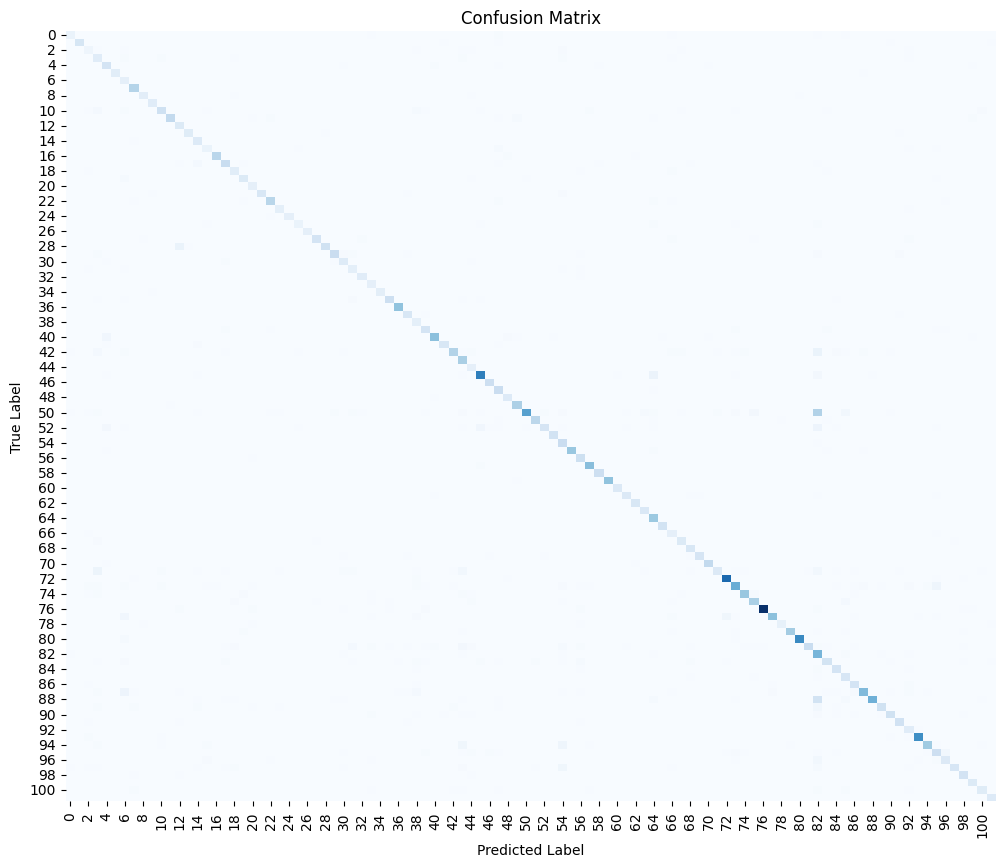

In [5]:
plot_confusion_matrix(y_true, y_pred)

## Error Analysis
Let's look at some specific examples where the model got it wrong.

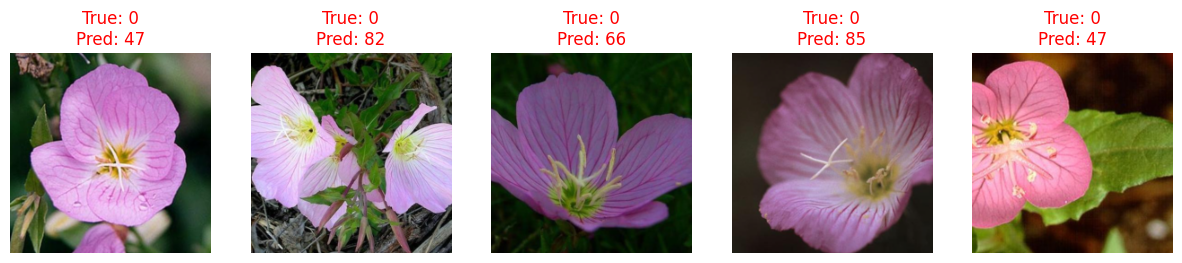

In [6]:
visualize_misclassifications(model, test_loader, DEVICE, num_images=5)

## Model Analysis & Findings

### Performance Relative to Dataset Complexity
Flower classification involves fine-grained features. ResNet50 typically captures these well even with only the final layer trained. If performance is low (<80%), it suggests we might need to unfreeze more layers (fine-tune the backbone).

### Trade-offs
- **Accuracy**: High with ResNet50, but requires more compute than MobileNet.
- **Inference Time**: Slower on CPU (approx 100-200ms per image sequence) but acceptable for batch interactions.
- **Model Size**: ~95MB (standard ResNet50 weights).

### Recommendations for Improvement
1. **Unfreeze Backbone**: Train the last 1-2 blocks of ResNet50 with a lower learning rate (1e-5).
2. **More Augmentation**: The dataset is small per class. Stronger augmentations (MixUp, CutMix) could help.
3. **Ensembling**: Combine predictions from EfficientNet and ResNet.